<a href="https://colab.research.google.com/github/buggytanmoy77/Chaos/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation of necessary libraries and tools

In [ ]:
!pip install -q diffusers transformers accelerate torch xformers
!pip install -q clip-interrogator safetensors huggingface_hub
!pip install -q git+https://github.com/huggingface/transformers.git

## Setting up CLIP

In [ ]:
!pip install --upgrade torchvision
!pip install clip-interrogator==0.6.0

from PIL import Image
from clip_interrogator import Config, Interrogator

ci = Interrogator(Config(
    clip_model_name="ViT-L-14/openai",
    device="cuda"
))

def get_prompt(image_path):
    image = Image.open(image_path).convert("RGB")
    return ci.interrogate(image)

## Download and Initialization of SD model

In [ ]:
!wget https://civitai.com/api/download/models/132760 -O custom_model.safetensors

from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_single_file(
    "custom_model.safetensors",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

## Extracting Prompts from Image Files

In [ ]:
image_paths = [
    "/content/test_img1.jpg",
    "/content/test_img2.jpg"
]

prompts = [get_prompt(path) for path in image_paths]
print("\nExtracted Prompts:", prompts)

## Combining and Summarizing Image Prompts Using Transformers

In [18]:
!pip install transformers
from transformers import pipeline

summarizer = pipeline("summarization", model="t5-base")

input_text = "Combine into a Stable Diffusion prompt: " + ", ".join(prompts)
summary = summarizer(input_text, max_length=70, min_length=30, do_sample=False)[0]['summary_text']

summary = summary + ", best quality, high resolution,"
print("Combined and Summarized Prompt:")
print(summary)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


Combined and Summarized Prompt:
arafed man in white robe standing in a corridor, arches adorned pillars, on an indian street, inspired by d. Howard Hitchcock . a painting of a woman with red and black jewelry and a red flower, gold madhubani, featured on artstattion , best quality, high resolution,


## Generation of Image

  0%|          | 0/100 [00:00<?, ?it/s]

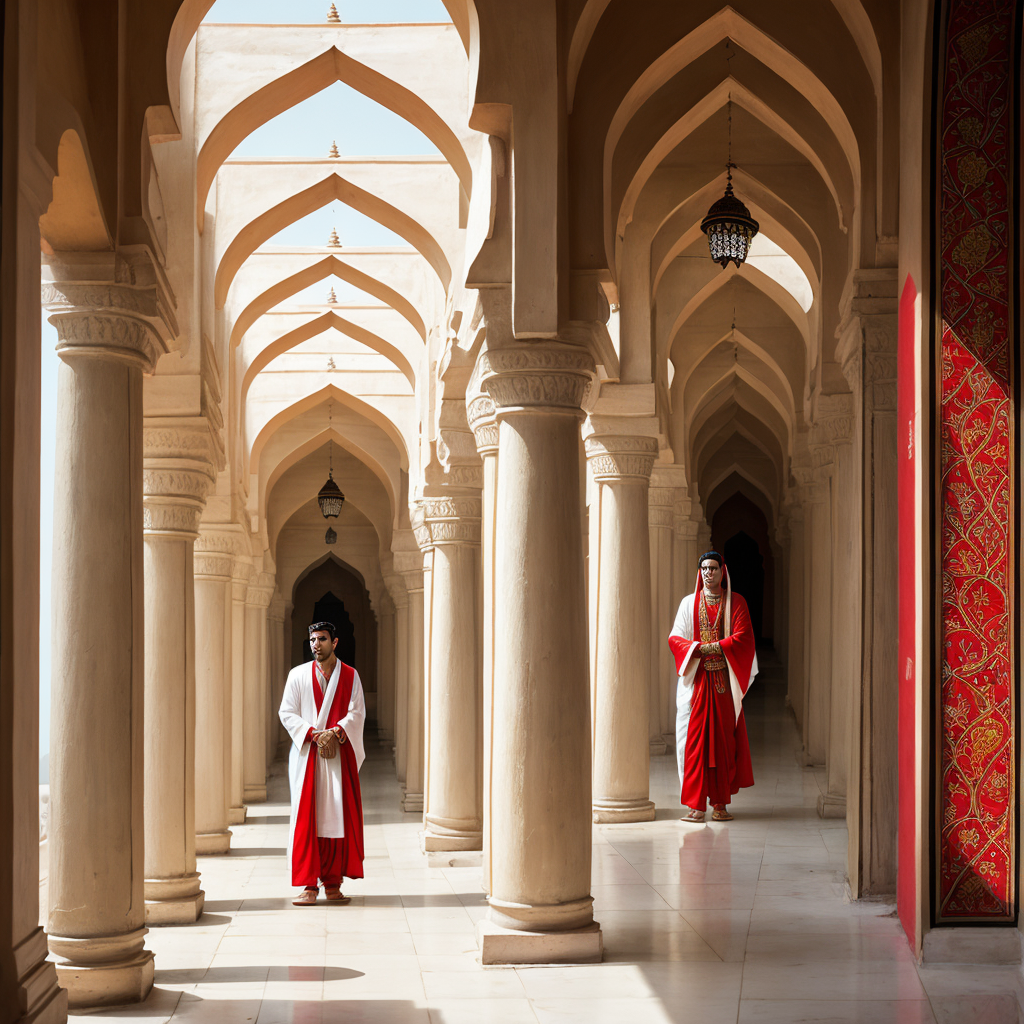

In [19]:
result = pipe(
    summary,
    negative_prompt="(deformed iris, deformed pupils, extra fingers), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck,ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, watermark, grainy, signature, cut off, draft, gender swap, gender change",
    num_inference_steps=100,
    guidance_scale=8,
    width=1024,
    height=1024,
    generator=torch.Generator(device="cuda").manual_seed(42)
).images[0]

result.save("output.png")
display(result)